In [28]:
import numpy as np
import pandas as pd
from scipy import stats

In [29]:
data= pd.read_csv('credit_card_default_analysis.csv')

In [30]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [31]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


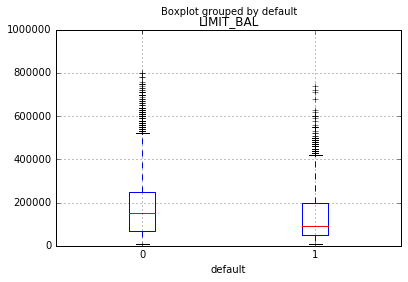

In [32]:
boxplot = data.boxplot('LIMIT_BAL', by='default',
return_type='axes')

In [33]:
nodefault=data[data.default==0]
default=data[data.default==1]

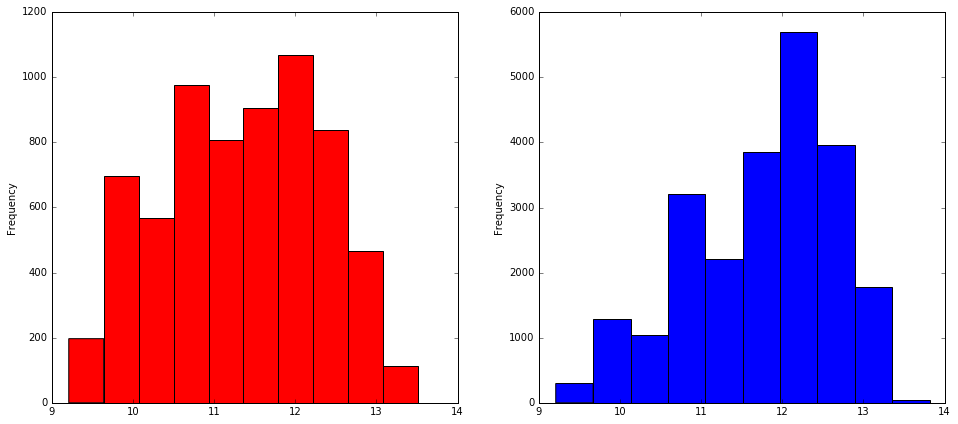

In [34]:
plt.figure(figsize(16,7))
plt.subplot(121)
np.log(default['LIMIT_BAL']).plot.hist(color='red')
plt.subplot(122)
np.log(nodefault['LIMIT_BAL']).plot.hist()

In [35]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from scipy.stats import median_test
defmedian=np.median(default['LIMIT_BAL'])
nodefmedian=np.median(nodefault['LIMIT_BAL'])
print("Default median",defmedian )
print("no default median",nodefmedian)
stat, p, med, tbl = median_test(default['LIMIT_BAL'], nodefault['LIMIT_BAL'])

('Default median', 90000.0)
('no default median', 150000.0)


In [36]:
flag=1.3471418011496707e-150<0.05
print(flag)
p

True


1.3471418011496707e-150

In [37]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [38]:
print ("p-value: %f" % permutation_test(default['LIMIT_BAL'], nodefault['LIMIT_BAL'],\
                                       max_permutations = 10000))

p-value: 0.000100


In [39]:
#В данном случае проверялась гипотеза о равентсве медиан кредитного лимита в 2 группах.
#Гипотеза была отвегнута на уровне 0,05, достигаемое значение 1.3471418011496707e-150
#Во втором случае проверялась непараметрическим критерием гипотеза о равентсве распределений
# кредитного лимита в двух группах, гипоьеза была отвергнута достигаемое значение 0.000100

#Оказалось что  в среднем люди у которых был дефолт имели боллее низкий кредитный лимит.
# Думаю результаты значимы с практической точки зрения

(<matplotlib.figure.Figure at 0x7ff50a57ac50>,
 OrderedDict([(('2', '1'), (0.0, 0.0, 0.6007296849087894, 0.2070725672962915)), (('2', '0'), (0.0, 0.21039482643250412, 0.6007296849087894, 0.78960517356749582)), (('1', '1'), (0.605704809286899, 0.0, 0.3942951907131012, 0.24086937664044927)), (('1', '0'), (0.605704809286899, 0.24419163577666189, 0.3942951907131012, 0.75580836422333808))]))

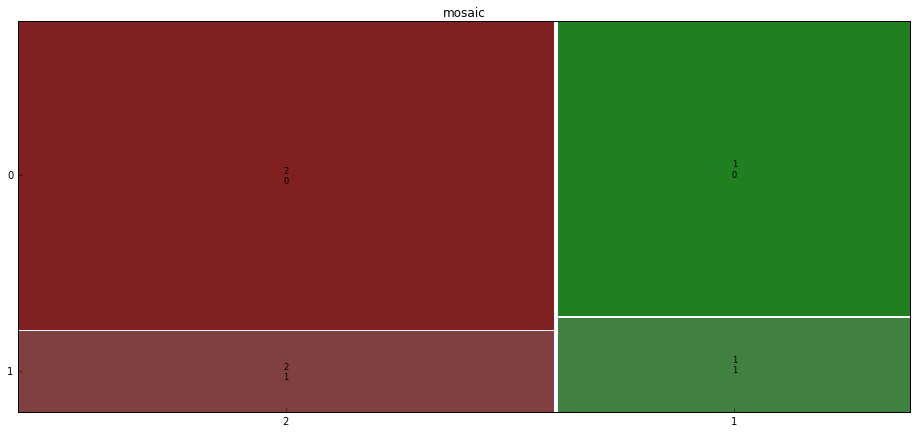

In [40]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(data, ['SEX', 'default'],title='mosaic')


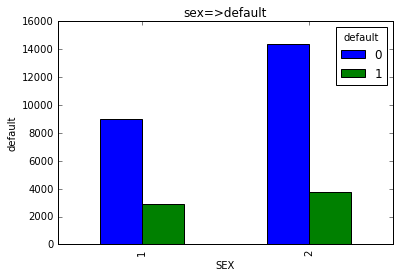

In [41]:
%matplotlib inline
pd.crosstab(data.SEX,data.default).plot(kind='bar')
plt.title('sex=>default')
plt.xlabel('SEX')
plt.ylabel('default')

In [42]:
#По исходным графикам видно что в выборке женщин больше мужчин, и при этом уровень дефолта у женщин 
# визуально тоже выше. Нулевая гипотеза будет заключатся в том что уровень дефолта не зависит от пола.
w_data=data[data.SEX==2]
m_data=data[data.SEX==1]
#Использую Z-критерий для двух долей.

In [43]:
import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [44]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [45]:
 proportions_diff_z_test(proportions_diff_z_stat_ind(w_data.default,m_data.default))

4.4728665216098307e-12

In [46]:
print(4.4728665216098307e-12<0.05)

True


In [47]:
print ("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(w_data.default,m_data.default))

95% confidence interval for a difference between proportions: [-0.043612, -0.024207]


In [48]:
# Из полученных данных видно что гендерный состав группы вернувших и не вернувших кредит 
# имеет значение, те влияние на уровне 0,05.Достигаемы уровень в данном случае 4.4728665216098307e-12
# Для этой задачи можно воспользовать статистикой критерия хи-квадрат.При этом создадим таблицу
# сопряжения
wsub_def_len=len(w_data[w_data.default==1])
wsub_notdef_len=len(w_data[w_data.default==0])
msub_def_len=len(m_data[m_data.default==1])
msub_notdef_len=len(m_data[m_data.default==0])


In [49]:
row1=[wsub_def_len,msub_def_len]
row2=[wsub_notdef_len,msub_notdef_len]

In [50]:
chidata=[row1,row2]
stats.chi2_contingency(chidata)

(47.708796890621109,
 4.9446789994120443e-12,
 1,
 array([[  4006.3744,   2629.6256],
        [ 14105.6256,   9258.3744]]))

In [51]:
print(4.9446789994120443e-12<0.05)

True


In [52]:
#И в данном случае можно сказать что состав гендерной группы имеет значение

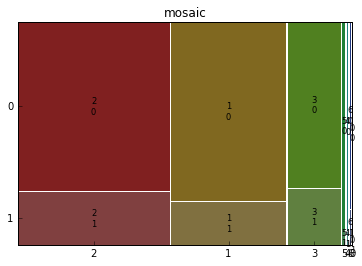

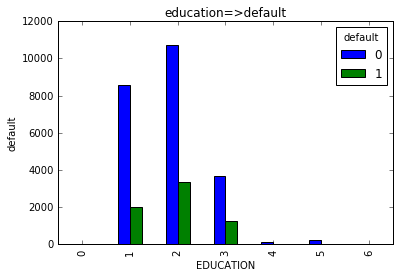

In [53]:
mosaic(data, ['EDUCATION', 'default'],title='mosaic')
pd.crosstab(data.EDUCATION,data.default).plot(kind='bar')
plt.title('education=>default')
plt.xlabel('EDUCATION')
plt.ylabel('default')


In [54]:
len(data[data.EDUCATION==5])

280

In [55]:
#В данном случае сложно сказать по графикам точное соотношение не возвратов. Видно что больше всего 
#дефолтов отмечено среди бакалавров, но бакаловров в группе больше всего.Попробуем построить 
#логистическую регрессию. При этом избавимся от данных в ходящих в категорию 5 и 6. 
educated_data=data[data.EDUCATION<5]
educated_data['EDUCATION'].value_counts()
doc_data=educated_data[educated_data['EDUCATION']==0]
doc_data=doc_data[doc_data.default==1]
len(doc_data)

0

In [56]:
df_educ = pd.get_dummies(educated_data['EDUCATION'],prefix='EDUCATION')
cols_to_remain = ['default']
data = educated_data[cols_to_remain].join(df_educ.ix[:, 'EDUCATION_1':])
#data['intercept'] = 1.0

In [57]:
import statsmodels.api as sm
train_cols = data.columns[1:]
logit = sm.Logit(data['default'], data[train_cols])

result = logit.fit()
print (result.summary())

Optimization terminated successfully.
         Current function value: 0.528534
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                29669
Model:                          Logit   Df Residuals:                    29665
Method:                           MLE   Df Model:                            3
Date:                Tue, 28 Jun 2016   Pseudo R-squ.:                0.003553
Time:                        01:03:43   Log-Likelihood:                -15681.
converged:                       True   LL-Null:                       -15737.
                                        LLR p-value:                 4.408e-24
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
EDUCATION_1    -1.4348      0.025    -58.184      0.000        -1.483    -1.386
EDUCATION_2    -1.1673    

In [58]:
print np.exp(result.params)


EDUCATION_1    0.238157
EDUCATION_2    0.311215
EDUCATION_3    0.336141
EDUCATION_4    0.060345
dtype: float64


In [59]:
# Из логистической регресси следует что наилучшим индикатором отдачи кредита образования это доктор.
# Выпускник школы может кредит не отдат..те он является индикатором неотдачи
# Из регресси видно что образование является значимым.И можно отбросить гипотезу о независимости
# на уровне 0,05 с поомщью критерия хи-квадрат
# Попробуем проверить гипотезу о независимости образования с помощью

In [61]:

doc_data=data[data.EDUCATION==0]
mag_data=data[data.EDUCATION==1]
bak_data=data[data.EDUCATION==2]
vip_data=data[data.EDUCATION==3]
nobr_data=data[data.EDUCATION==4]
doc_def_len=len(doc_data[doc_data.default==1])
doc_nodef_len=len(doc_data[doc_data.default==0])
mag_data_def_len=len(mag_data[mag_data.default==1])
mag_data_nodef_len=len(mag_data[mag_data.default==0])
bak_data_def_len=len(bak_data[bak_data.default==1])
bak_data_nodef_len=len(bak_data[bak_data.default==0])
vip_data_def_len=len(vip_data[vip_data.default==1])
vip_data_nodef_len=len(vip_data[vip_data.default==0])
nobr_data_def_len=len(nobr_data[nobr_data.default==1])
nobr_data_nodef_len=len(nobr_data[nobr_data.default==0])
educ1=[doc_def_len,mag_data_def_len,bak_data_def_len,vip_data_def_len,nobr_data_def_len]
educ2=[doc_nodef_len,mag_data_nodef_len,bak_data_nodef_len,vip_data_nodef_len,nobr_data_nodef_len]
chieducdata=[educ1,educ2]
stats.chi2_contingency(chieducdata)

AttributeError: 'DataFrame' object has no attribute 'EDUCATION'

In [62]:
print(3.4068885315527483e-25<0.05)

True


In [63]:
#Отбрасывает нулевую гипотезу,уровень достижения 3.4068885315527483e-25

expdata=stats.contingency.expected_freq(chieducdata)
observeddata=np.array(chieducdata).flatten()
exp=expdata.flatten()


In [64]:
strdef=""
for i in range(0,len(exp)):
    if i<5:
        strdef="default"
    else:
        strdef="nodefault"
    print("expected: %f  observed: %f" % (exp[i],observeddata[i])+":"+strdef)

expected: 3.119081  observed: 0.000000:default
expected: 2358.247666  observed: 2036.000000:default
expected: 3125.764266  observed: 3330.000000:default
expected: 1095.465638  observed: 1237.000000:default
expected: 27.403350  observed: 7.000000:default
expected: 10.880919  observed: 14.000000:nodefault
expected: 8226.752334  observed: 8549.000000:nodefault
expected: 10904.235734  observed: 10700.000000:nodefault
expected: 3821.534362  observed: 3680.000000:nodefault
expected: 95.596650  observed: 116.000000:nodefault


In [65]:
#Оставим толко индикаторные данные те 1 = замужем/женат; 2 = холост;
data_marriage=data[(data.MARRIAGE==1) | (data.MARRIAGE==2)]

#mosaic(data_marriage, ['MARRIAGE', 'default'],title='mosaic')
pd.crosstab(data_marriage.MARRIAGE,data.default).plot(kind='bar')
plt.title('MARRIAGE=>default')
plt.xlabel('MARRIAGE')
plt.ylabel('default')

AttributeError: 'DataFrame' object has no attribute 'MARRIAGE'

In [23]:
data_marriage.MARRIAGE.value_counts()

2    15964
1    13659
Name: MARRIAGE, dtype: int64

In [24]:
#На первый взгляд кажется что дефолт не зависит от статуса замужества.Проверить можно с помощью
#с поомщью критерия Z-критерий для двух долей или логистической регрессии
dummy_marriage=pd.get_dummies(data_marriage.MARRIAGE,prefix='MARRIAGE')
column_name=data_marriage.columns.values.tolist()
column_name.remove('MARRIAGE')
cols_to_remain = ['default']
logdata = data_marriage[cols_to_remain].join(dummy_marriage)
logdata.head()

,default,MARRIAGE_1,MARRIAGE_2
0,1,1.0,0.0
1,1,0.0,1.0
2,0,0.0,1.0
3,0,1.0,0.0
4,0,1.0,0.0


In [26]:
train_cols =logdata.columns[1:]
logit1 = sm.Logit(logdata['default'], logdata[train_cols])
result1 = logit1.fit()
print (result1.summary())

NameError: name 'sm' is not defined

In [27]:
print np.exp(result1.params)

NameError: name 'result1' is not defined

In [226]:
#data_marriage['MARRIAGE_INDIC']=data_marriage.MARRIAGE.apply(lambda x : 1 if x==1 else 0)
notmar_data=data_marriage[data_marriage.MARRIAGE==2]
mar_data=data_marriage[data_marriage.MARRIAGE==1]


In [227]:
 proportions_diff_z_test(proportions_diff_z_stat_ind(notmar_data.default,mar_data.default))

1.4485143440268189e-07

In [228]:
print(1.4485143440268189e-07<0.05)

True


In [233]:
#Гипотезу о независимости можно отвергнуть.

notmarriagedef=len(data_marriage[(data_marriage.MARRIAGE==2) & (data_marriage.default==1)])
notmarriagenotdef=len(data_marriage[(data_marriage.MARRIAGE==2) & (data_marriage.default==0)])

marriagedef=len(data_marriage[(data_marriage.MARRIAGE==1) & (data_marriage.default==1)])
marriagenotdef=len(data_marriage[(data_marriage.MARRIAGE==1)  & (data_marriage.default==0)])

row1_obsers=[notmarriagedef,marriagedef]
row2_observ=[notmarriagenotdef,marriagenotdef]
observ=[row1_obsers,row2_observ]
stats.chi2_contingency(observ)

(27.509409092957899,
 1.5633210355976673e-07,
 1L,
 array([[  3528.21483307,   3018.78516693],
        [ 12435.78516693,  10640.21483307]]))

In [234]:
print( 1.5633210355976673e-07<0.05)

True


[[3341, 3206], [12623, 10453]]

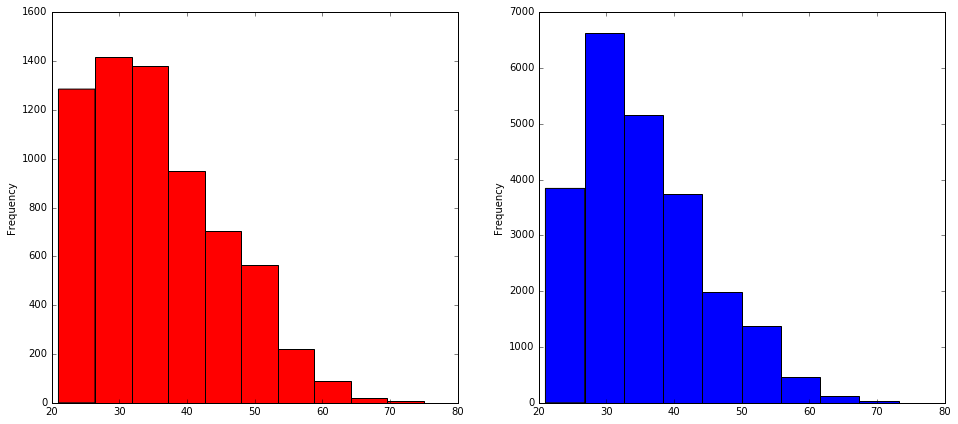

In [254]:
plt.figure(figsize(16,7))
plt.subplot(121)
(default['AGE']).plot.hist(color='red')
plt.subplot(122)
(nodefault['AGE']).plot.hist()

In [260]:
#необходимо проверить гипотезу о раветсве медианных возрастов вернувших и нет кредиты
defmedianage=np.median(default['AGE'])
nodefmedianage=np.median(nodefault['AGE'])
print("Default median",defmedianage )
print("no default median",nodefmedianage)
stat, p, med, tbl = median_test(default['AGE'], nodefault['AGE'])

('Default median', 34.0)
('no default median', 34.0)


In [263]:
med

34.0

In [262]:
print ("p-value: %f" % permutation_test(default['AGE'], nodefault['AGE'],\
                                       max_permutations = 10000))

p-value: 0.015700


In [ ]:
#С помощью не параметрического критерия  было отброшена гипотеза об одинаковом распределении на уровне 
#0.05